<h1 style="font-family:Corbel Light; color:#e54b87">Projet 4 : Anticipez les besoins en consommation de bâtiments </h1>

<h2 style="font-family:Corbel Light; color:#737373">Contexte</h2>

Le client, la ville de Seattle, s’est fixé un objectif de neutralité carbone en 2050. 
Pour atteindre cet objectif il a défini plusieurs actions dont réduire la consommation totale d’énergie et les émissions de CO2 des bâtiments non destinés à l’habitation.

Il a donc besoin de monitorer ces deux cibles pour adapter sa stratégie. 

<h2 style="font-family:Corbel Light; color:#737373">Mission</h2>

Proposer deux modèles de prédiction : l’un permettant de prédire la consommation totale d’énergie des bâtiments non destinés à l’habitation, l’autre leurs émissions de CO2. 

<h2 style="font-family:Corbel Light; color:#737373">Data Source</h2>

https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

<h2 style="font-family:Corbel Light; color:#737373">Requirements</h2>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
import toolbox
from math import ceil

%matplotlib inline
pd.options.display.float_format = '{:_.2f}'.format

In [2]:
python_version = !python -V
print('python version :', python_version,'\n')

print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.21.5 

matplotlib version :  3.5.1 

seaborn version :  0.12.1 



**Versions utilisées :**

- python : Python 3.9.12 
- seaborn    :  0.12.1
- matplotlib :  3.5.1 
- numpy  :  1.21.5 
- pandas :  1.4.2

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">Étape 1</span> : Analyse exploratoire</h2>

<h3 style="font-family:Corbel Light; color:#737373">Inspection des données</h3>

In [3]:
data_building = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

On affiche les 5 premières lignes du dataframe 

In [4]:
data_building.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98_101.00,0659000030,...,1_156_514.25,3_946_027.00,12_764.53,1_276_453.00,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98_101.00,0659000220,...,950_425.19,3_242_851.00,51_450.82,5_145_082.00,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98_101.00,0659000475,...,14_515_435.00,49_526_664.00,14_938.00,1_493_800.00,False,NaN,Compliant,NaN,2_089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98_101.00,0659000640,...,811_525.31,2_768_924.00,18_112.13,1_811_213.00,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98_121.00,0659000970,...,1_573_448.62,5_368_607.00,88_039.98,8_803_998.00,False,NaN,Compliant,NaN,505.01,2.88


On regarde la taille du dataframe

In [5]:
data_building.shape

(3376, 46)

On vérifie que toutes les données datent de 2016

In [6]:
data_building["DataYear"].value_counts()

2016    3376
Name: DataYear, dtype: int64

On regarde la structure des données

In [7]:
data_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Nos cibles à prédire sont 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions'. Elle sont numériques et continues. Il s'agit donc d'un problème de régression

<h3 style="font-family:Corbel Light; color:#737373">Nettoyage</h3>

<h4 style="font-family:Corbel Light; color:#737373">Filtre individus</h4>

On va sélectionner uniquement les bâtiments non-destinés à l'habitation en filtrant tous ceux utilisés principalement pour une occupation privée (i.e. on écarte toutes les lignes contenant multifamily dans les colonnes : 'PrimaryPropertyYype', 'BuildingType' ou 'LargestPropertyType')

In [8]:
list(data_building['BuildingType'].unique())

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [9]:
data_building = toolbox.drop_contains(data_building, 'BuildingType', 'multifamily')

1708 lignes supprimées, i.e. 50.59 % des données


In [10]:
list(data_building['PrimaryPropertyType'].unique())

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'University',
 'Small- and Mid-Sized Office',
 'Self-Storage Facility',
 'Warehouse',
 'Large Office',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital',
 'Residence Hall',
 'Distribution Center',
 'Worship Facility',
 'Supermarket / Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Low-Rise Multifamily',
 'Office']

In [11]:
data_building = toolbox.drop_contains(data_building, 'PrimaryPropertyType', 'multifamily')

3 lignes supprimées, i.e. 0.18 % des données


In [12]:
data_building = toolbox.drop_contains(data_building, 'LargestPropertyUseType', 'multifamily')

9 lignes supprimées, i.e. 0.54 % des données


In [13]:
data_building.shape

(1656, 46)

<h4 style="font-family:Corbel Light; color:#737373">Traitement des doublons</h4>

On vérifie qu'il n'y a pas de doublons en utilisant l'identifiant unique attribué à chaque propriété par le Seattle Benchmarking Ordinance

In [14]:
data_building.loc[data_building.duplicated(subset='OSEBuildingID')].shape[0]

0

In [15]:
# on vérifie qu'il n'y a pas de doublons même sans les cibles et l'identifiant unique
data_building.drop(columns=['OSEBuildingID', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']).duplicated().sum() 

0

<h4 style="font-family:Corbel Light; color:#737373">Filtre variables</h4>

On va sélectionner les variables pertinentes pour prédire la consommation d'énergie et les émissions de gaz à effet de serre (en faisant attention à ne sélectionner ni des variables avec trop de valeurs manquantes ni des variables directement liées aux cibles pour éviter la fuite de données).

Coefficient de conversion source-site : Electricité 2.80, Steam 1.20, Gaz naturel 1.05

Donc en principe: 
- SourceEUI(kBtu/sf) ~ (NaturalGas(kBtu) * 1.05 + Electricity(kBtu) * 2.80 + SteamUse(kBtu) * 1.20) / PropertyGFATotal
- SiteEnergyUse(kBtu) ~ NaturalGas(kBtu) + Electricity(kBtu) + SteamUse(kBtu)

A prédire :
- SiteEnergyUse(kBtu)
- TotalGHGEmissions

La surface totale est égale à la somme des surfaces du batiment et du parking

In [16]:
data_building['PropertyGFATotal'].equals(data_building[['PropertyGFABuilding(s)', 'PropertyGFAParking']].sum(axis=1))

True

In [17]:
toolbox.missing_values_by_column(data_building)

,VARIABLES,Number of Missing Values,Missing Values (%)
0,OSEBuildingID,0,0.00
19,PropertyGFABuilding(s),0,0.00
18,PropertyGFAParking,0,0.00
17,PropertyGFATotal,0,0.00
16,NumberofFloors,0,0.00
40,DefaultData,0,0.00
14,YearBuilt,0,0.00
12,Latitude,0,0.00
11,Neighborhood,0,0.00
10,CouncilDistrictCode,0,0.00


In [18]:
features_to_keep = ['PropertyGFATotal', 'LargestPropertyUseTypeGFA',
                    'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',  # surfaces
                    'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',  # fonctions
                    'NumberofFloors', 'NumberofBuildings',  # taille du bâtiment
                    'YearBuilt', 'Neighborhood',  # ancienneté/localisation du bâtiment
                    'ENERGYSTARScore',  # voir l'utilité
                    'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', # cibles à prédire
                    # pour déduire la nature et proportion des sources utilisées
                    'NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)',
                    'ComplianceStatus',  # pour nettoyage
                    'SiteEUI(kBtu/sf)',  'GHGEmissionsIntensity', 'ListOfAllPropertyUseTypes',
                    'PropertyGFABuilding(s)'  # pour faire des analyses
                    ]

print('On garde', len(features_to_keep), 'variables')

On garde 22 variables


In [19]:
data_building = data_building[features_to_keep]

<h4 style="font-family:Corbel Light; color:#737373">Traitement des valeurs manquantes</h4>

In [20]:
data_building.isnull().sum()

PropertyGFATotal                      0
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseTypeGFA     812
ThirdLargestPropertyUseTypeGFA     1312
LargestPropertyUseType                6
SecondLargestPropertyUseType        812
ThirdLargestPropertyUseType        1312
NumberofFloors                        0
NumberofBuildings                     2
YearBuilt                             0
Neighborhood                          0
ENERGYSTARScore                     566
SiteEnergyUse(kBtu)                   2
TotalGHGEmissions                     2
NaturalGas(kBtu)                      2
Electricity(kBtu)                     2
SteamUse(kBtu)                        2
ComplianceStatus                      0
SiteEUI(kBtu/sf)                      3
GHGEmissionsIntensity                 2
ListOfAllPropertyUseTypes             2
PropertyGFABuilding(s)                0
dtype: int64

On commence par supprimer les observations pour lesquelles il manque des valeurs pour des variables essentielles (cibles, energy star score)

In [21]:
data_building = data_building.dropna(subset=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])

In [22]:
missing_data = data_building.isnull().sum()
missing_data[missing_data > 0]

LargestPropertyUseTypeGFA            2
SecondLargestPropertyUseTypeGFA    592
ThirdLargestPropertyUseTypeGFA     934
LargestPropertyUseType               2
SecondLargestPropertyUseType       592
ThirdLargestPropertyUseType        934
dtype: int64

Il manque seulement 2 valeurs pour 'LargestPropertyUseType'. Ce n'est pas beaucoup on peut les supprimer.

In [23]:
data_building.dropna(subset=['LargestPropertyUseType'], inplace=True)

On vérifie que : 
- les valeurs manquantes dans 'SecondLargestPropertyUseType' correspondent toutes à des propriétés n'ayant qu'une seule fonction
- les valeurs manquantes dans 'ThirdLargestPropertyUseType' correspondent toutes à des propriétés ayant deux usages maximum

Si oui, on peut remplacer les NaN par des 0 dans les colonnes GFA

In [24]:
data_building.loc[data_building['SecondLargestPropertyUseType'].isnull(
)]['ListOfAllPropertyUseTypes'].str.count(',').value_counts(normalize=True)

0   1.00
Name: ListOfAllPropertyUseTypes, dtype: float64

In [25]:
data_building.loc[data_building['ThirdLargestPropertyUseType'].isnull(
)]['ListOfAllPropertyUseTypes'].str.count(',').value_counts(normalize=True)

0   0.64
1   0.36
Name: ListOfAllPropertyUseTypes, dtype: float64

In [26]:
data_building['SecondLargestPropertyUseTypeGFA'] = data_building['SecondLargestPropertyUseTypeGFA'].fillna(0)
data_building['ThirdLargestPropertyUseTypeGFA'] = data_building['ThirdLargestPropertyUseTypeGFA'].fillna(0)

In [27]:
missing_data = data_building.isnull().sum()
missing_data[missing_data > 0]

SecondLargestPropertyUseType    590
ThirdLargestPropertyUseType     932
dtype: int64

In [28]:
data_building.shape

(1088, 22)

<h4 style="font-family:Corbel Light; color:#737373">Traitement des valeurs 'non compliant'</h4>

On nettoie le reste du dataset en s'appuyant sur la variable 'ComplianceStatus'

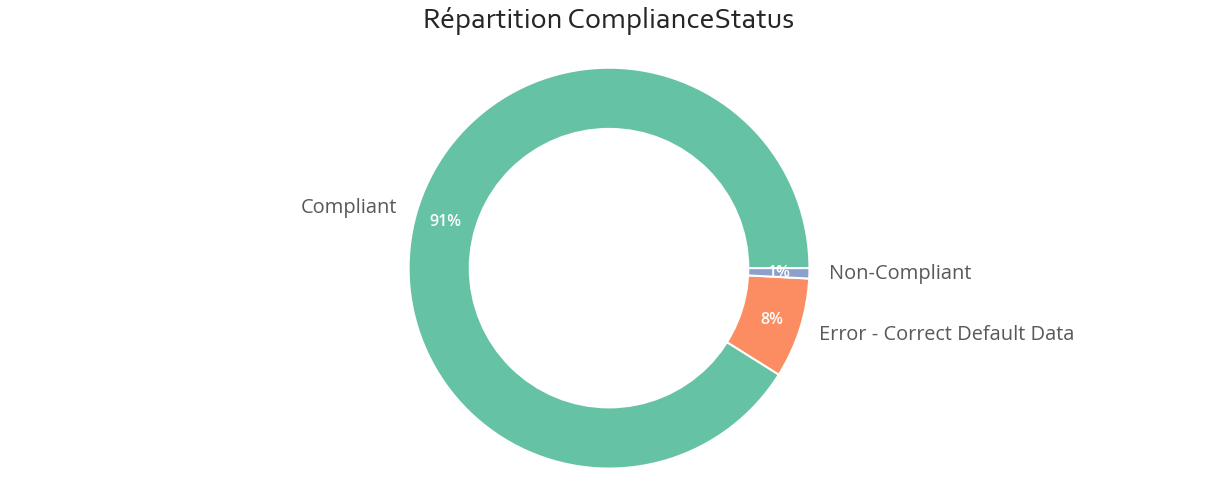

In [29]:
toolbox.plot_donut(data_building, 'ComplianceStatus', 'Set2',
                   '#595959', 'Répartition ComplianceStatus', (17, 7))

'Error - Correct Default Data' : une valeur a été mise par défaut (correspond donc à une valeur moyenne pas à la vraie mesure du bâtiment). 
Problème : il semble difficile de déterminer quelle valeur a été remplie par défaut, on les supprime toutes (représentent que 8% du jeu de données)

Non-Compliant : représentent que 1% du jeu de données - on peut toutes les supprimer

In [30]:
data_building = data_building.loc[data_building['ComplianceStatus'] == 'Compliant'].copy()
data_building['ComplianceStatus'].unique()

array(['Compliant'], dtype=object)

In [31]:
data_building.drop(columns='ComplianceStatus', inplace=True)

In [32]:
data_building.shape

(991, 21)

<h4 style="font-family:Corbel Light; color:#737373">Traitement des valeurs atypiques</h4>

On regarde si certaines consommations se démarquent beaucoup des autres et sont visibles graphiquement

In [33]:
data_building.describe()

,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,NumberofFloors,NumberofBuildings,YearBuilt,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu),SiteEUI(kBtu/sf),GHGEmissionsIntensity,PropertyGFABuilding(s)
count,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00,991.00
mean,129_294.79,106_712.09,22_045.57,3_094.98,5.11,1.02,1_963.08,63.59,8_894_197.49,195.61,1_983_866.75,6_275_859.63,602_398.94,68.51,1.41,112_768.03
std,210_660.34,172_487.32,56_611.43,21_259.64,8.11,0.52,31.94,28.84,25_890_565.89,864.22,11_338_811.57,15_754_883.52,6_452_966.25,70.03,2.03,183_284.33
min,16_300.00,8_061.00,0.00,0.00,0.00,0.00,1_900.00,1.00,79_711.80,-0.80,0.00,-115_417.00,0.00,2.10,-0.02,3_636.00
25%,31_469.00,27_819.00,0.00,0.00,1.00,1.00,1_937.00,44.00,1_269_607.62,20.30,0.00,786_005.50,0.00,34.55,0.33,30_140.50
50%,53_620.00,48_159.00,0.00,0.00,3.00,1.00,1_968.00,71.00,2_804_534.00,49.98,404_925.00,1_866_104.00,0.00,51.70,0.75,50_734.00
75%,127_311.50,104_828.50,15_462.00,0.00,5.00,1.00,1_988.00,88.00,7_753_878.25,144.60,1_392_215.50,5_656_959.50,0.00,74.80,1.71,108_137.00
max,1_952_220.00,1_680_937.00,639_931.00,459_748.00,99.00,9.00,2_015.00,100.00,448_385_312.00,16_870.98,297_909_000.00,274_532_495.00,134_943_456.00,834.40,34.09,1_765_970.00


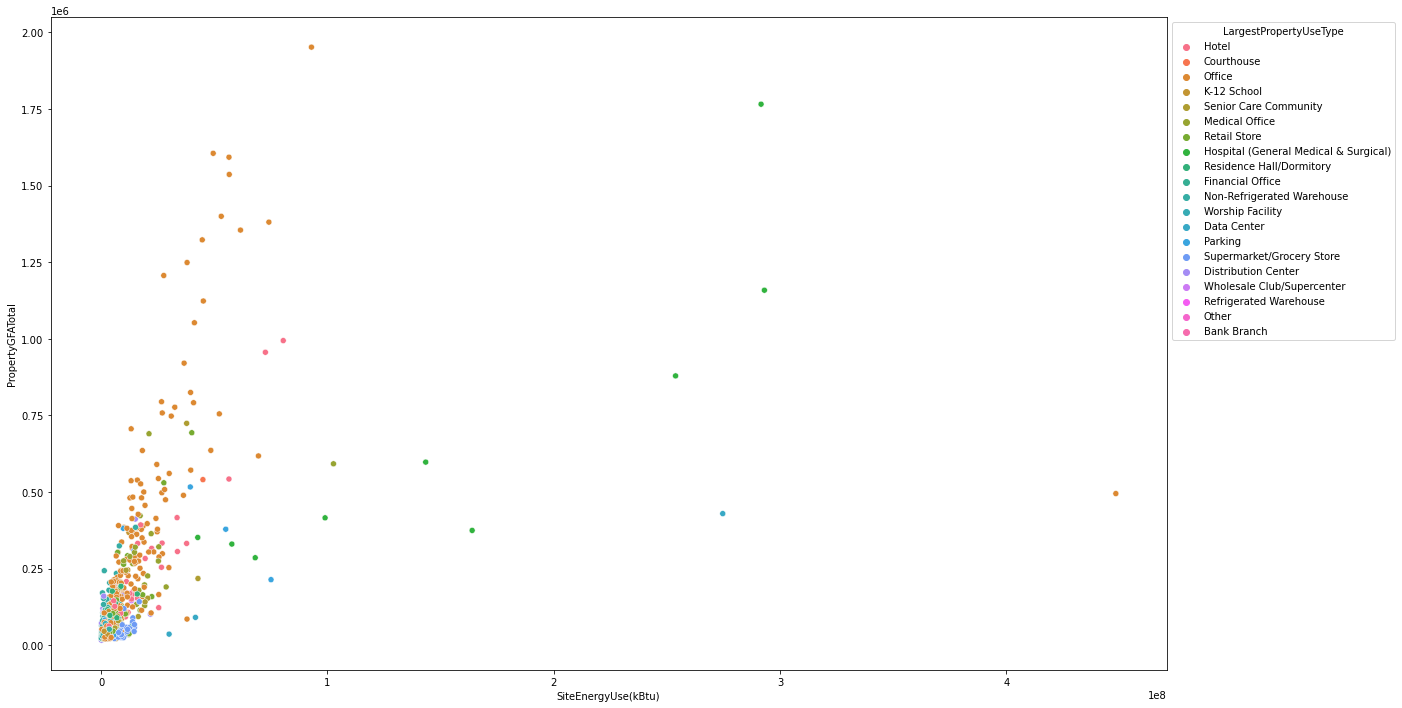

In [34]:
plt.figure(figsize=(20,12))
ax = sns.scatterplot(data_building, x='SiteEnergyUse(kBtu)', y='PropertyGFATotal', hue='LargestPropertyUseType')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

On voit que les outliers les plus visibles graphiquement sont majoritairement des hôpitaux

In [35]:
data_building.loc[data_building['SiteEnergyUse(kBtu)'] >= 100_000_000][['SiteEnergyUse(kBtu)', 'LargestPropertyUseType']]

,SiteEnergyUse(kBtu),LargestPropertyUseType
35,448_385_312.00,Office
124,253_832_464.00,Hospital (General Medical & Surgical)
167,143_423_024.00,Hospital (General Medical & Surgical)
170,293_090_784.00,Hospital (General Medical & Surgical)
558,274_682_208.00,Data Center
618,291_614_432.00,Hospital (General Medical & Surgical)
1690,102_673_696.00,Medical Office
3264,163_945_984.00,Hospital (General Medical & Surgical)


On vérifie qu'il n'y a pas de bâtiments qui produisent plus d'énergie qu'ils n'en consomment (ce qui serait atypique)

In [36]:
data_building.loc[(data_building['SiteEnergyUse(kBtu)'] <= 0)
                  | (data_building['TotalGHGEmissions'] <= 0)]

,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,NumberofFloors,NumberofBuildings,YearBuilt,...,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu),SiteEUI(kBtu/sf),GHGEmissionsIntensity,ListOfAllPropertyUseTypes,PropertyGFABuilding(s)
513,57176,39_500.00,15_000.00,5_500.00,Supermarket/Grocery Store,Retail Store,"Personal Services (Health/Beauty, Dry Cleaning...",1,1.00,2008,...,31.00,12_525_174.00,0.00,0.00,0.00,0.00,208.80,0.00,"Personal Services (Health/Beauty, Dry Cleaning...",57176
3206,52000,48_159.00,0.00,0.00,Office,NaN,NaN,6,1.00,2013,...,100.00,342_726.09,-0.80,0.00,-115_417.00,0.00,7.10,-0.02,Office,52000


On a deux bâtiments qui ont une émission de gaz à effet de serre nulle ou négative, on les supprime du jeu données

In [37]:
data_building = data_building.loc[~(data_building['TotalGHGEmissions'] <= 0)]
print("Taille jeu de données :", data_building.shape)

Taille jeu de données : (989, 21)


On regarde le nombre d'outliers calculés selon la méthode des boxplots pour chaque cible :
- valeurs en dehors de [Q1 - whis * IQ ; Q3 + whis * IQ] avec IQ = Q3-Q1 ; *Par défaut whis = 1.5*

In [38]:
outliers_energy = toolbox.count_outliers(data_building, ['SiteEUI(kBtu/sf)'], 3)

Il y a 52 outliers, soit 5.26% du jeu de données


In [39]:
outliers_emissions = toolbox.count_outliers(data_building, ['GHGEmissionsIntensity'], 3)

Il y a 33 outliers, soit 3.34% du jeu de données


Dans un premier temps, on va garder toutes les valeurs atypiques restantes, même si elles risquent de plomber un peu le modèle (car nous n'avons pas beaucoup de données, on ne peut pas se permettre de perdre plus d'information)

<h3 style="font-family:Corbel Light; color:#737373">Etude du dataset</h3>

Regardons quels types de biens immobiliers nous avons dans notre jeu de données. 

On a essentiellement des bureaux (41%) et des entrepôts non réfrigérés (15%)

In [40]:
usetype_df = toolbox.build_frequency_df_with_thresh(data_building, 'LargestPropertyUseType', 0.01, 'other (frequency < {} %)')

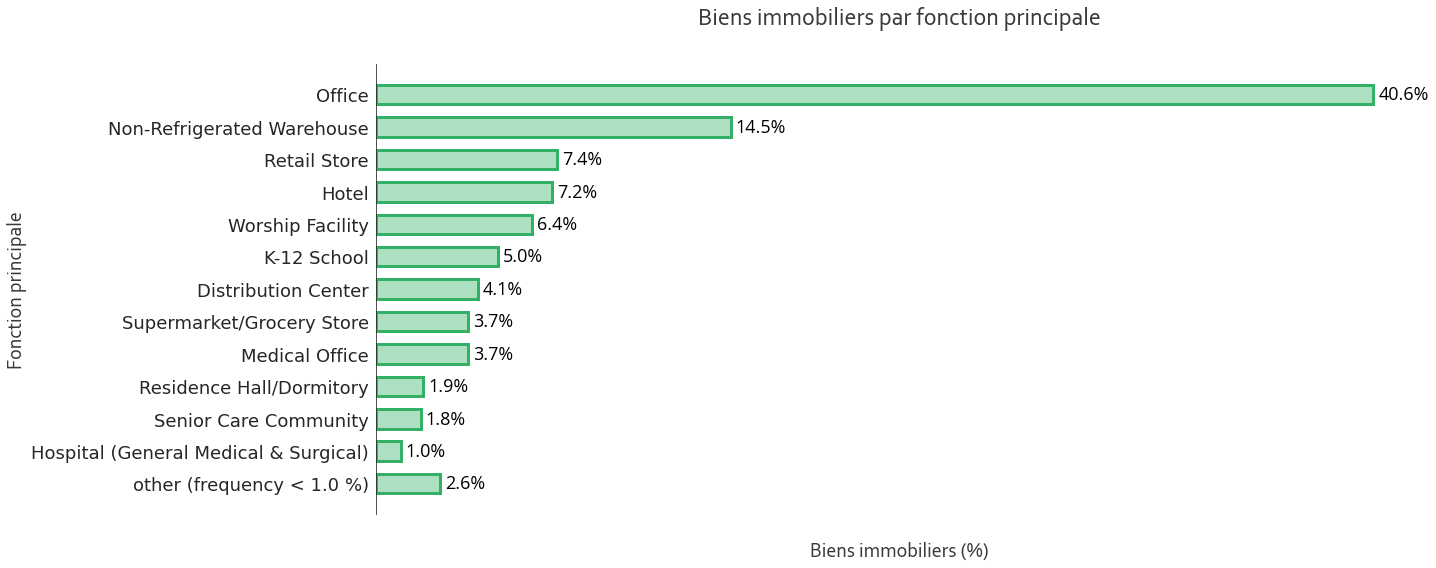

In [41]:
color = sns.color_palette("husl", 8)[3]
titles = {'chart_title': 'Biens immobiliers par fonction principale',
          'y_title': 'Fonction principale',
          'x_title': 'Biens immobiliers (%)'}

toolbox.plot_empirical_distribution(usetype_df['LargestPropertyUseType'], color, titles, (20, 8), vertical=False)

<h4 style="font-family:Corbel Light; color:#737373">Consommation d'énergie</h4>

<h5 style="font-family:Corbel Light; color:#737373">Cible</h5>

On regarde la distribution de la cible. Elle est très étalée sur la droite (asymétrie positive). Il pourrait donc être intéressant de la passer au log, pour faciliter le travail de certains modèles.

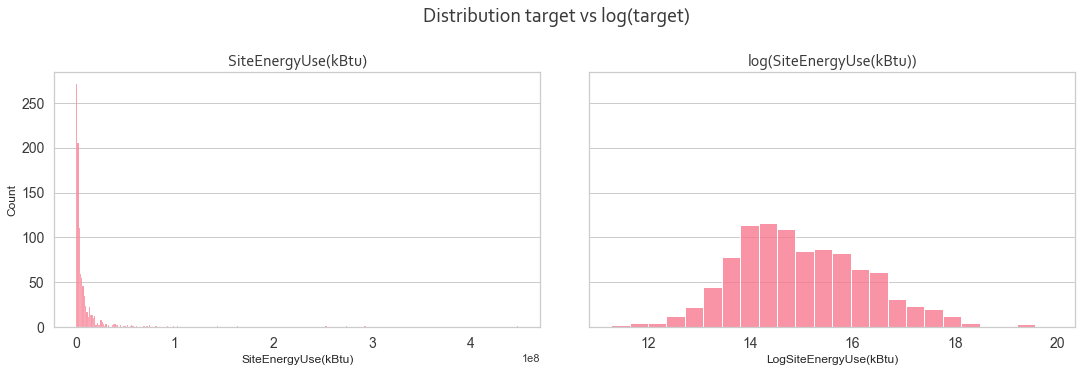

In [42]:
toolbox.display_distribution_log(data_building, 'SiteEnergyUse(kBtu)')

<h5 style="font-family:Corbel Light; color:#737373">Fonction propriété</h5>

Regardons la distribution de la cible "consommation d'énergie" pour la variable Fonction principale du bâtiment. 

Ca nous donnera des pistes pour éventuellement regrouper certaines modalités (si leurs distribution et fonction sont similaires)

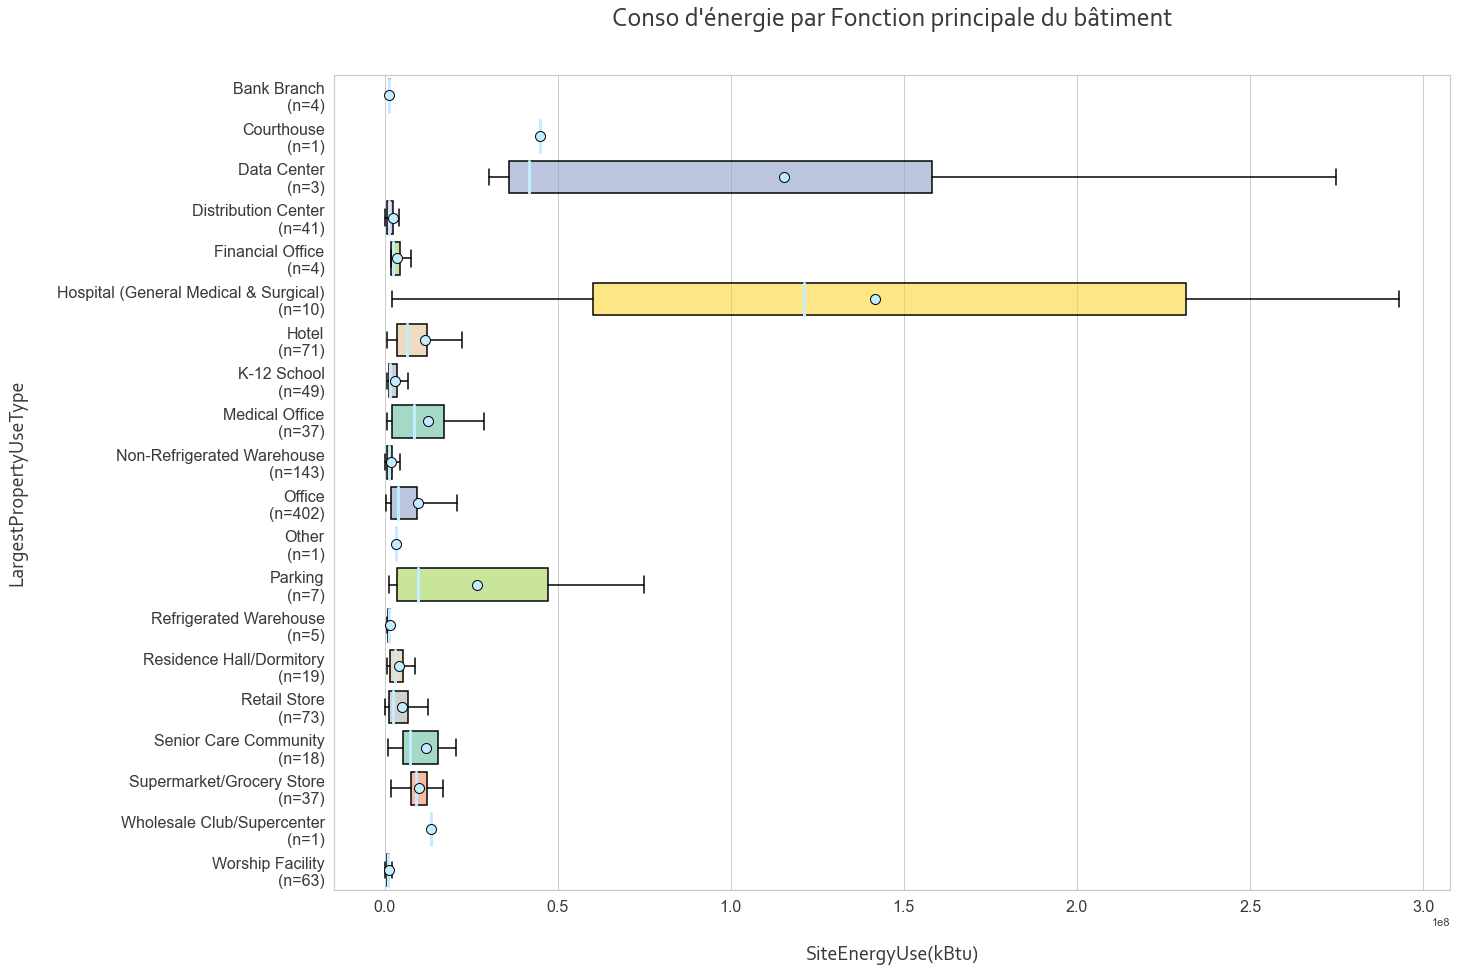

In [43]:
title_boxplot = 'Conso d\'énergie par Fonction principale du bâtiment\n'
toolbox.plot_boxplot(data_building.sort_values('LargestPropertyUseType'),
                     'SiteEnergyUse(kBtu)', title_boxplot, (20, 15), 'LargestPropertyUseType')

<h5 style="font-family:Corbel Light; color:#737373">Localisation</h5>

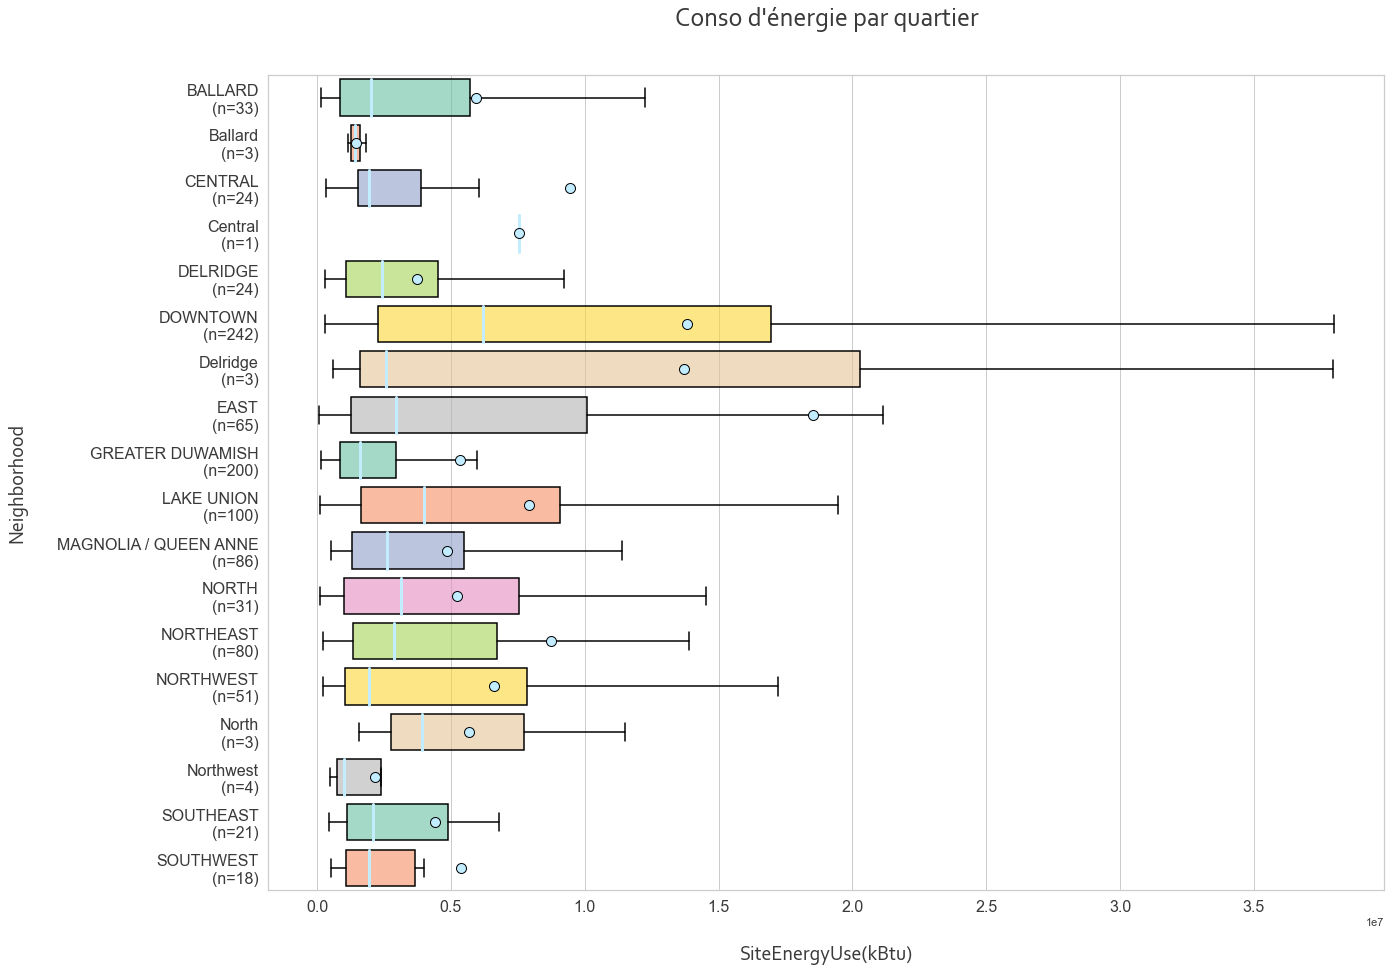

In [44]:
title_boxplot = 'Conso d\'énergie par quartier\n'
toolbox.plot_boxplot(data_building.sort_values('Neighborhood'),
                     'SiteEnergyUse(kBtu)', title_boxplot, (20, 15), 'Neighborhood')

On peut regarder si des bâtiments avec une même fonction sont concentrés dans certains quartiers (ex: quartier des affaires avec beaucoup de bureaux)

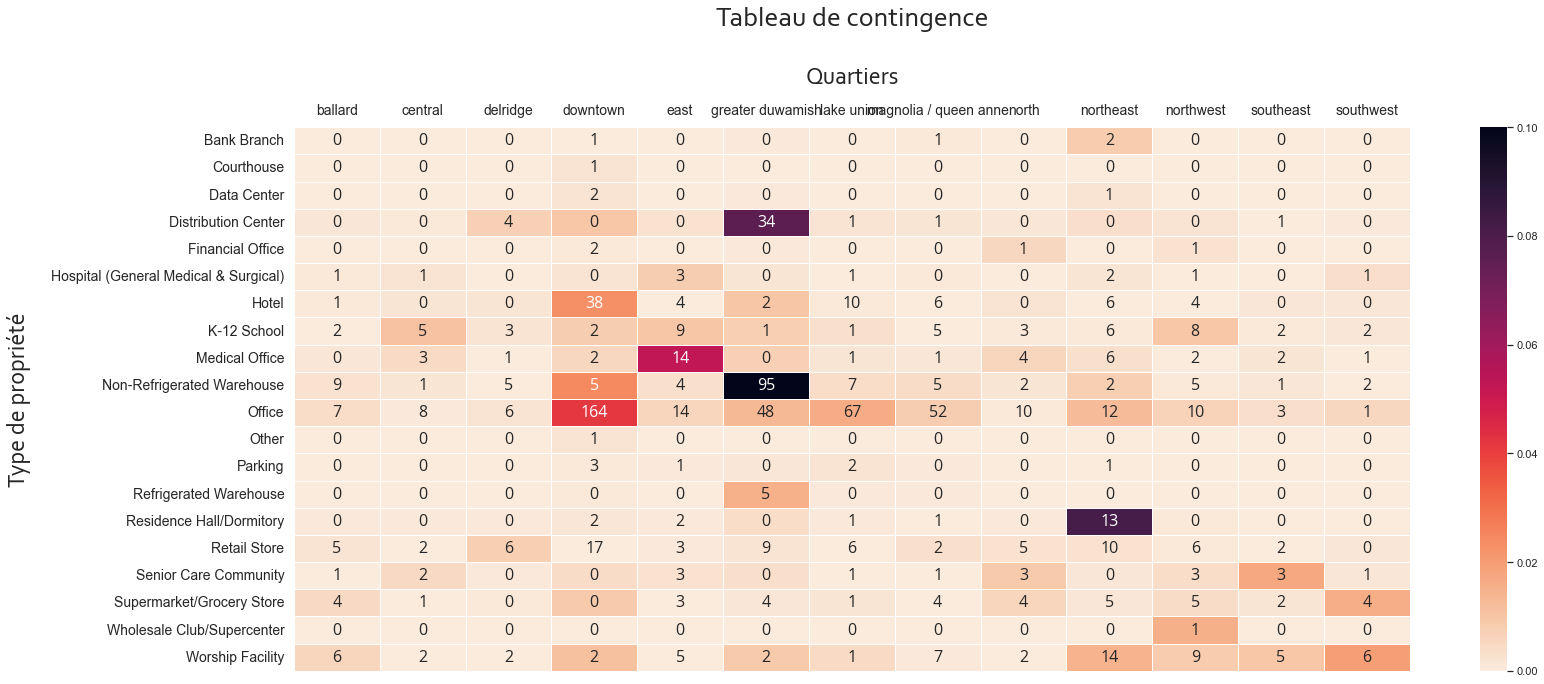

In [45]:
titles = {'chart_title': 'Tableau de contingence',
          'y_title': 'Type de propriété',
          'x_title': 'Quartiers'}

data_building['Neighborhood'] = data_building['Neighborhood'].str.lower()
contingence_table = pd.crosstab(data_building['LargestPropertyUseType'],
                                data_building['Neighborhood'],
                                dropna=True,
                                margins=True,
                                margins_name="Total")

xi_table, xi_n = toolbox.build_xi_table(contingence_table)

toolbox.plot_heatmap(xi_table.iloc[:-1, :-1],
                     round(xi_table.max().max(), 1),
                     titles, (25, 10), 'd',
                     annotation=contingence_table.iloc[:-1, :-1])

On voit que : 
- la majorité des entrepôts se trouve dans greater duwamish (refrigerated warehouse, non-refrigerated warehouse, distribution center)
- la majorité des bureaux et des hôtels dans le centre ville
- les hopitaux et cabinets médicaux dans l'est

<h5 style="font-family:Corbel Light; color:#737373">Efficacité énergétique</h5>

On peut regarder si certains types de bâtiments consomment beaucoup plus ou beaucoup moins que les autres  au regard de leur superficie. 
Ca nous permettrait de les regrouper selon un genre d'"efficience énergétique". Ex: le groupe des bâtiments qui consomment peu par rapport à leur taille.

In [46]:
energy_byusetype = data_building.pivot_table(index='LargestPropertyUseType',
                                             values=['LargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)'],
                                             aggfunc='sum')

energy_byusetype = energy_byusetype.reset_index()
energy_byusetype.rename({'index': 'LargestPropertyUseType'}, inplace=True)
energy_byusetype.head()

,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu)
0,Bank Branch,84_847.00,5_515_146.25
1,Courthouse,537_150.00,44_984_468.00
2,Data Center,314_997.00,346_401_338.00
3,Distribution Center,2_496_908.00,103_946_755.19
4,Financial Office,173_224.00,14_678_541.12


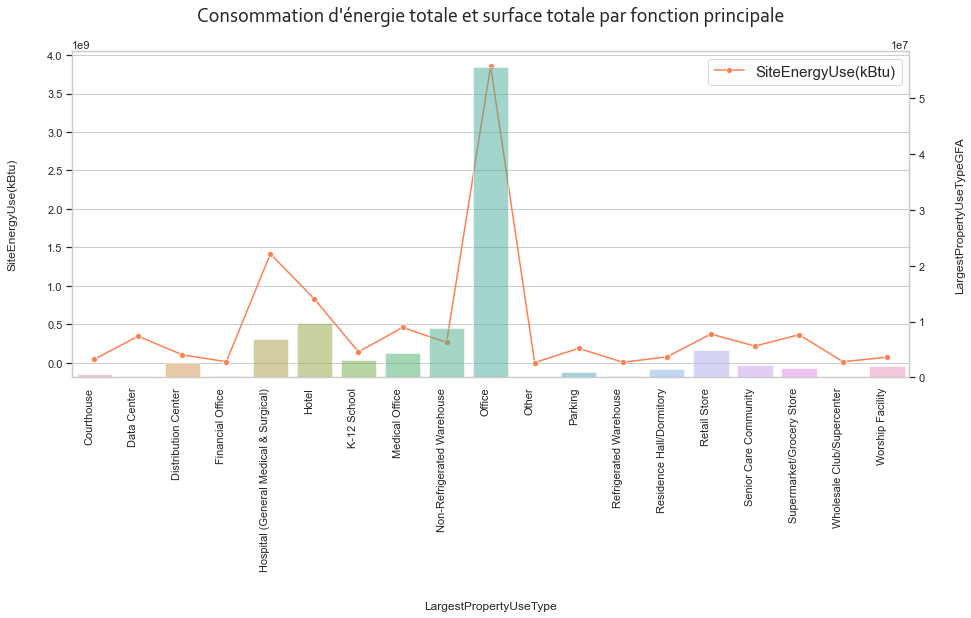

In [47]:
sns.set_theme(style='whitegrid', palette='Set2')
fig, ax1 = plt.subplots(figsize=(15, 6))

sns.lineplot(data=energy_byusetype.loc[1:], 
             x='LargestPropertyUseType',
             y='SiteEnergyUse(kBtu)', 
             marker='o', sort=False, ax=ax1, color='coral')

ax2 = ax1.twinx()

sns.barplot(data=energy_byusetype.loc[1:], 
            x='LargestPropertyUseType',
            y='LargestPropertyUseTypeGFA', 
            alpha=0.5, ax=ax2)

ax2.grid(False)

ax1.set_xticklabels(labels=ax2.axes.get_xticklabels(), rotation=90, ha='right')
ax1.grid(False, axis='x')

ax1.legend(labels=['SiteEnergyUse(kBtu)'], fontsize=15)
plt.title('Consommation d\'énergie totale et surface totale par fonction principale',
          fontname='Corbel', fontsize=20, pad=30)
plt.show()

On voit que les datacenter, et hopitaux consomment beaucoup pour la superficie qu'ils couvrent. Alors que les entrepots non réfrigérés semblent consommer moins par rapport à leur taille. Quant aux bureaux, leur consommation semble proportionnelle à leur taille.

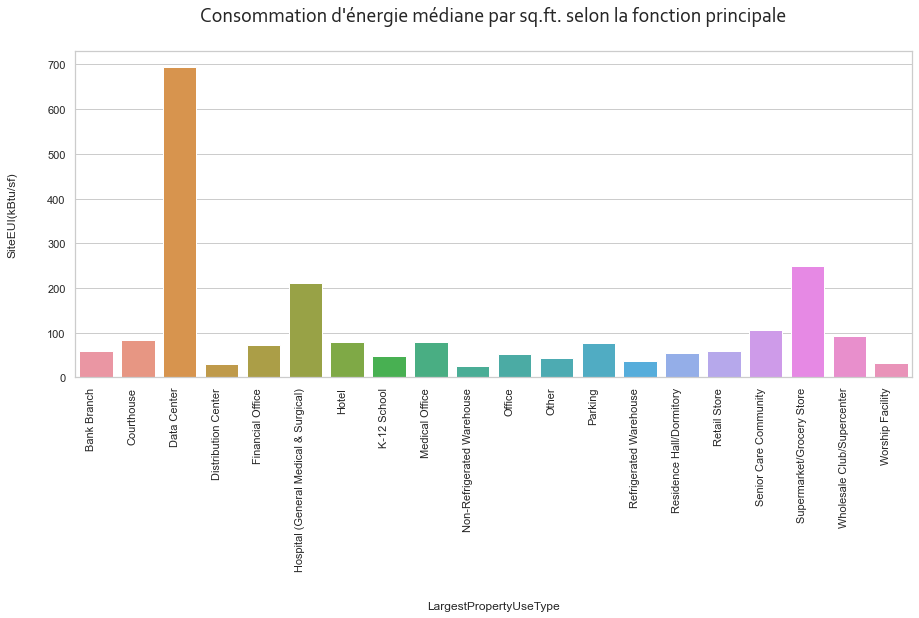

In [48]:
energy_intensity_byusetype = pd.DataFrame(data_building.groupby(
    'LargestPropertyUseType')['SiteEUI(kBtu/sf)'].median()).reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(energy_intensity_byusetype,
            x='LargestPropertyUseType',
            y='SiteEUI(kBtu/sf)')

plt.xticks(rotation=90, ha='right')
plt.title('Consommation d\'énergie médiane par sq.ft. selon la fonction principale',
          fontname='Corbel', fontsize=20, pad=30)
plt.show()

<h5 style="font-family:Corbel Light; color:#737373">Ancienneté bâtiment</h5>

Regardons si, de manière générale, les bâtiments plus anciens consomment plus. 

In [49]:
energy_by_year_df = pd.DataFrame(data_building.groupby('YearBuilt')['SiteEnergyUse(kBtu)'].median()).reset_index()

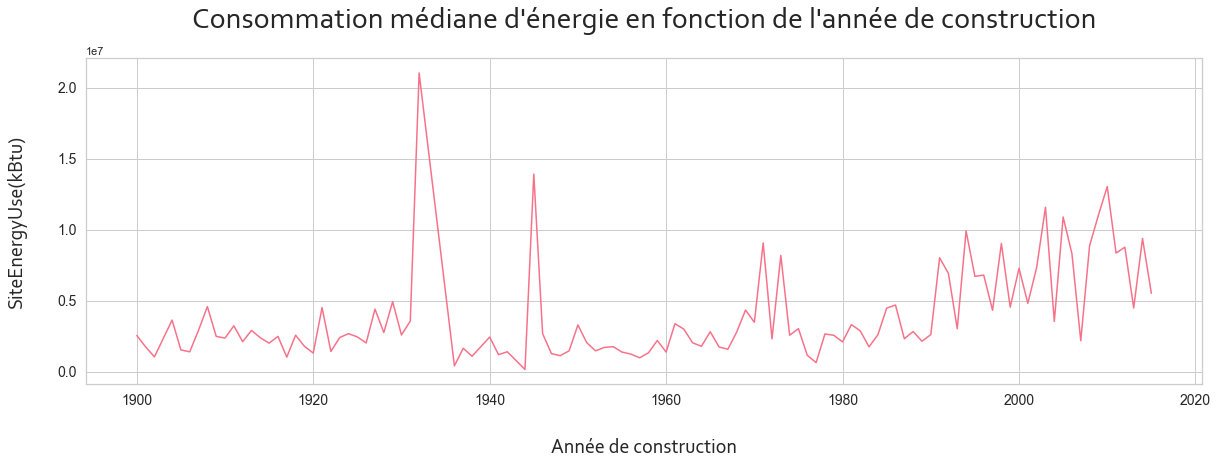

In [50]:
titles = {'title': 'Consommation médiane d\'énergie en fonction de l\'année de construction',
          'xlabel': 'Année de construction',
          'ylabel': 'SiteEnergyUse(kBtu)'}

toolbox.display_lineplot(energy_by_year_df,
                         'YearBuilt',
                         'SiteEnergyUse(kBtu)',
                         (20, 6), titles)

Regardons par type de bâtiment

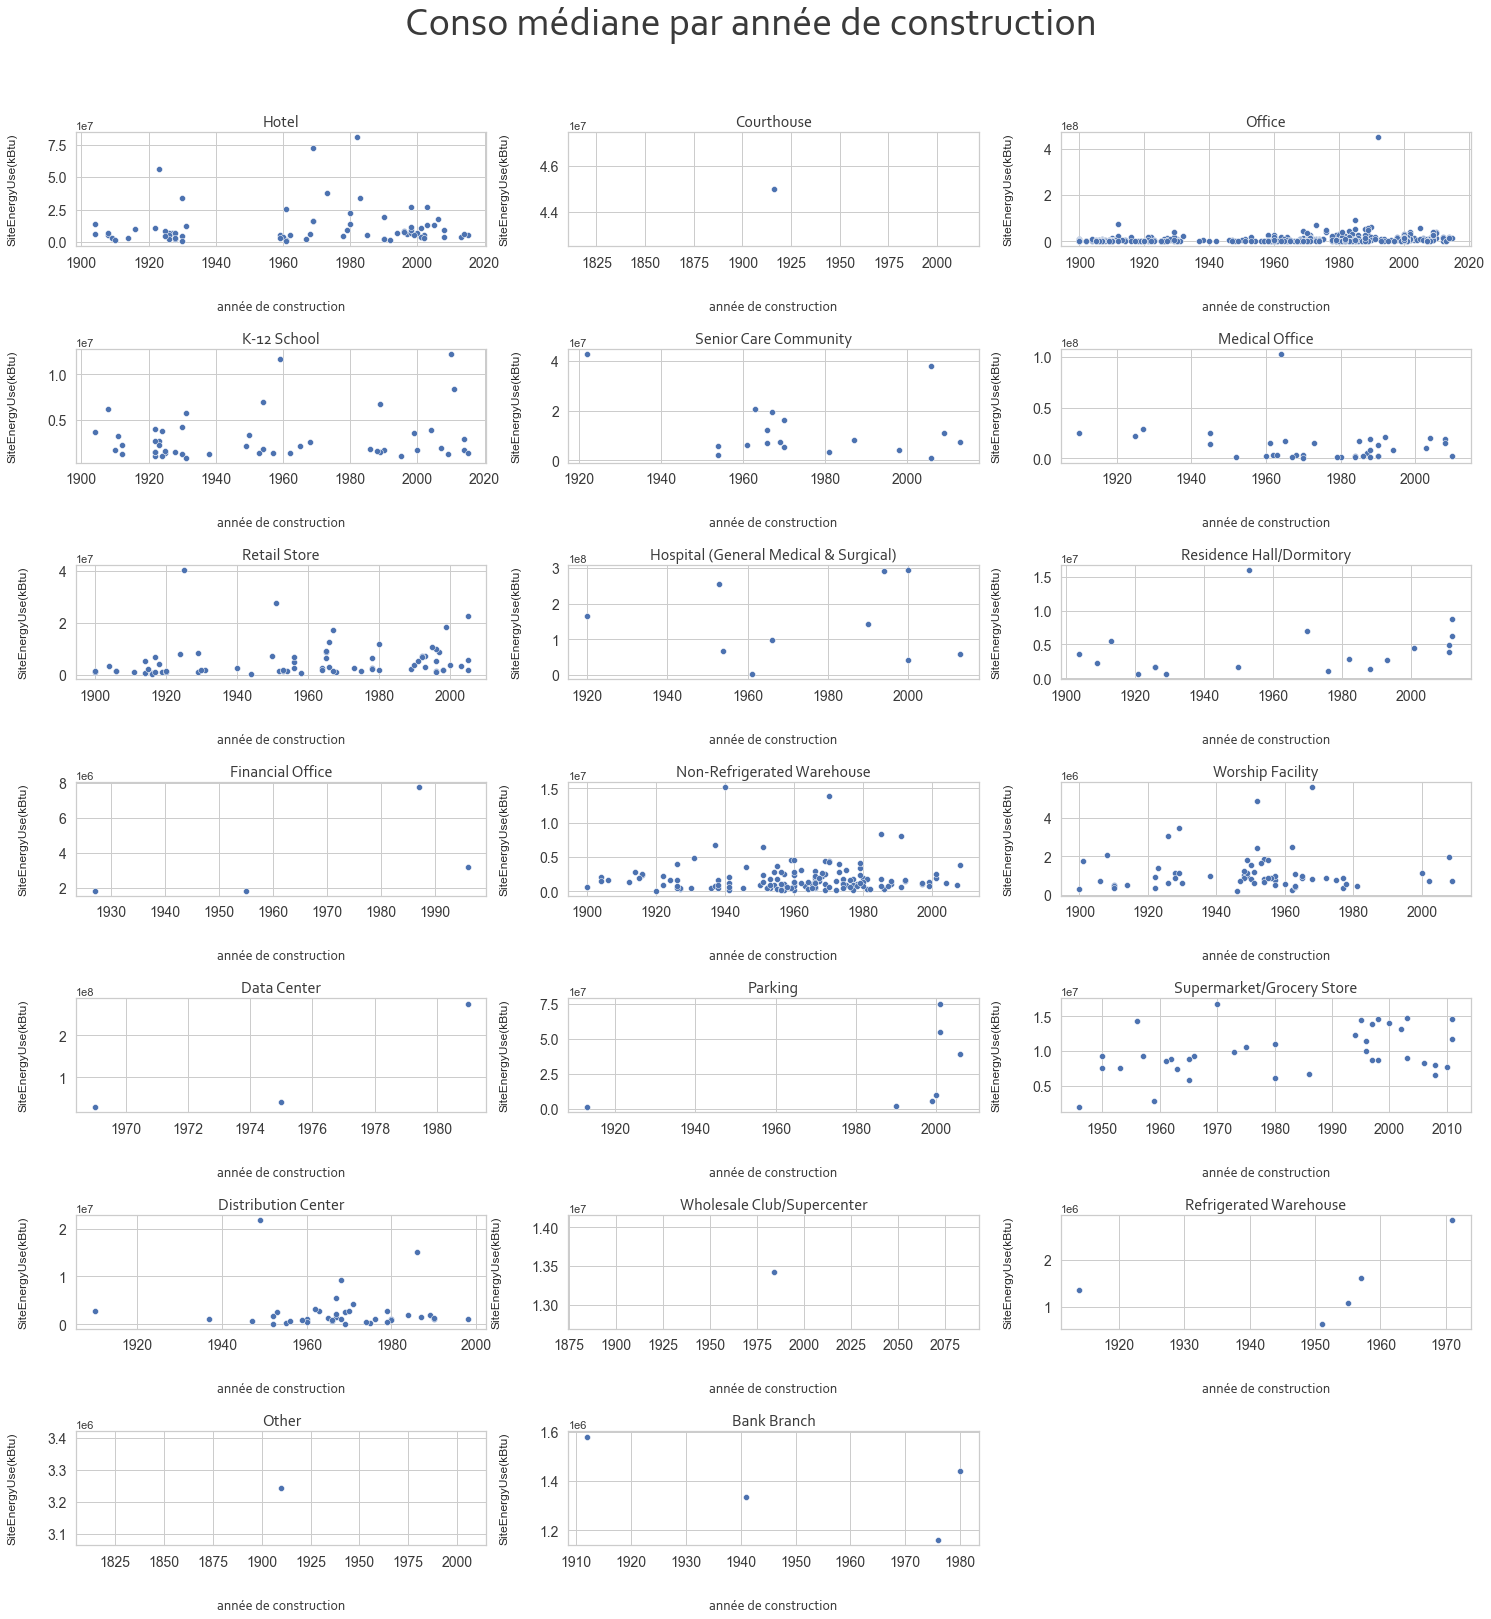

In [51]:
titles = {'title': 'Conso médiane par année de construction',
          'xlabel': 'année de construction'}

toolbox.display_scatter_by(data_building,
                           'LargestPropertyUseType',
                           'YearBuilt',
                           'SiteEnergyUse(kBtu)',
                           3, titles, (25, 25))

Pour la plupart des catégories de bâtiments, on a surtout l'impression que certains individus consomment plus mais que ce n'est pas lié à l'année de construction. Pour les supermarchés cependant, il semblerait que la tendance soit à l'augmentation.

<h4 style="font-family:Corbel Light; color:#737373">Emissions CO2</h4>

<h5 style="font-family:Corbel Light; color:#737373">Cible</h5>

On regarde la distribution de la cible. Elle est très étalée sur la droite (asymétrie positive). Il pourrait donc être intéressant de la passer aussi au logarithme, pour faciliter le travail de certains modèles.

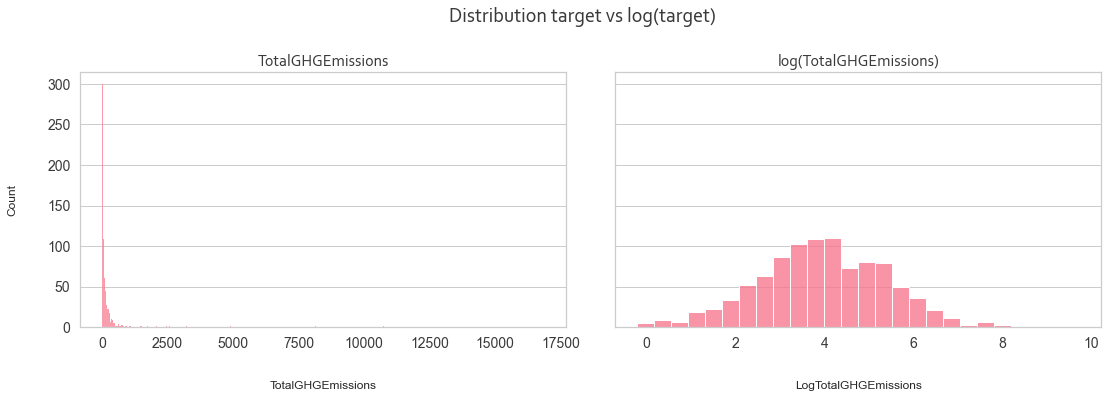

In [52]:
toolbox.display_distribution_log(data_building, 'TotalGHGEmissions')

<h5 style="font-family:Corbel Light; color:#737373">Fonctions propriété</h5>

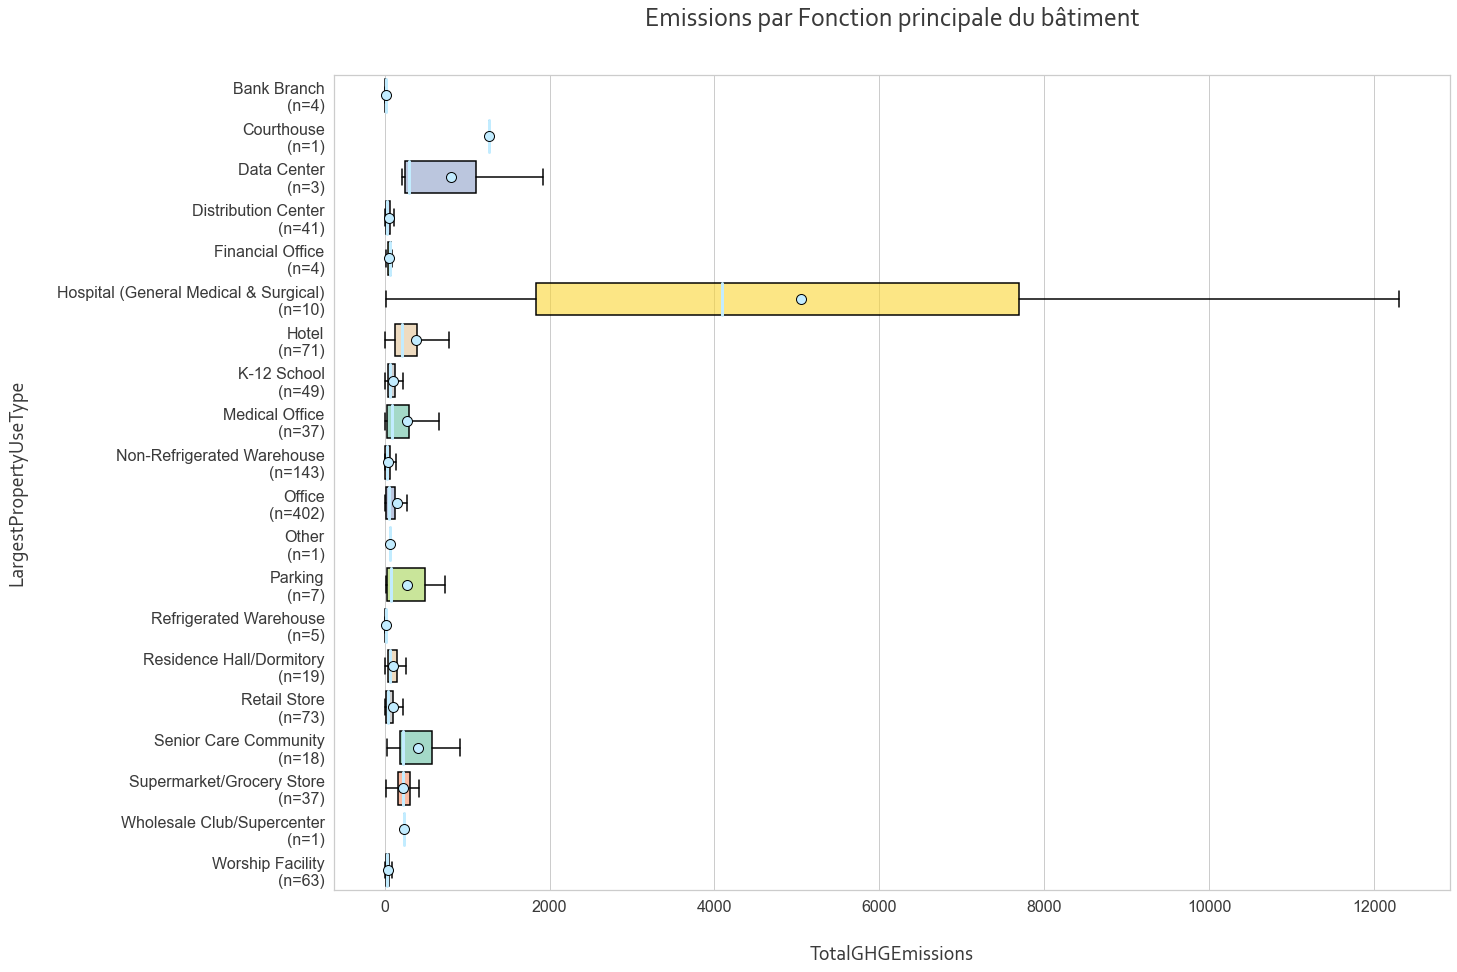

In [53]:
title_boxplot = 'Emissions par Fonction principale du bâtiment\n'
toolbox.plot_boxplot(data_building.sort_values('LargestPropertyUseType'),
                     'TotalGHGEmissions', title_boxplot, (20, 15), 'LargestPropertyUseType')

<h5 style="font-family:Corbel Light; color:#737373">Localisation</h5>

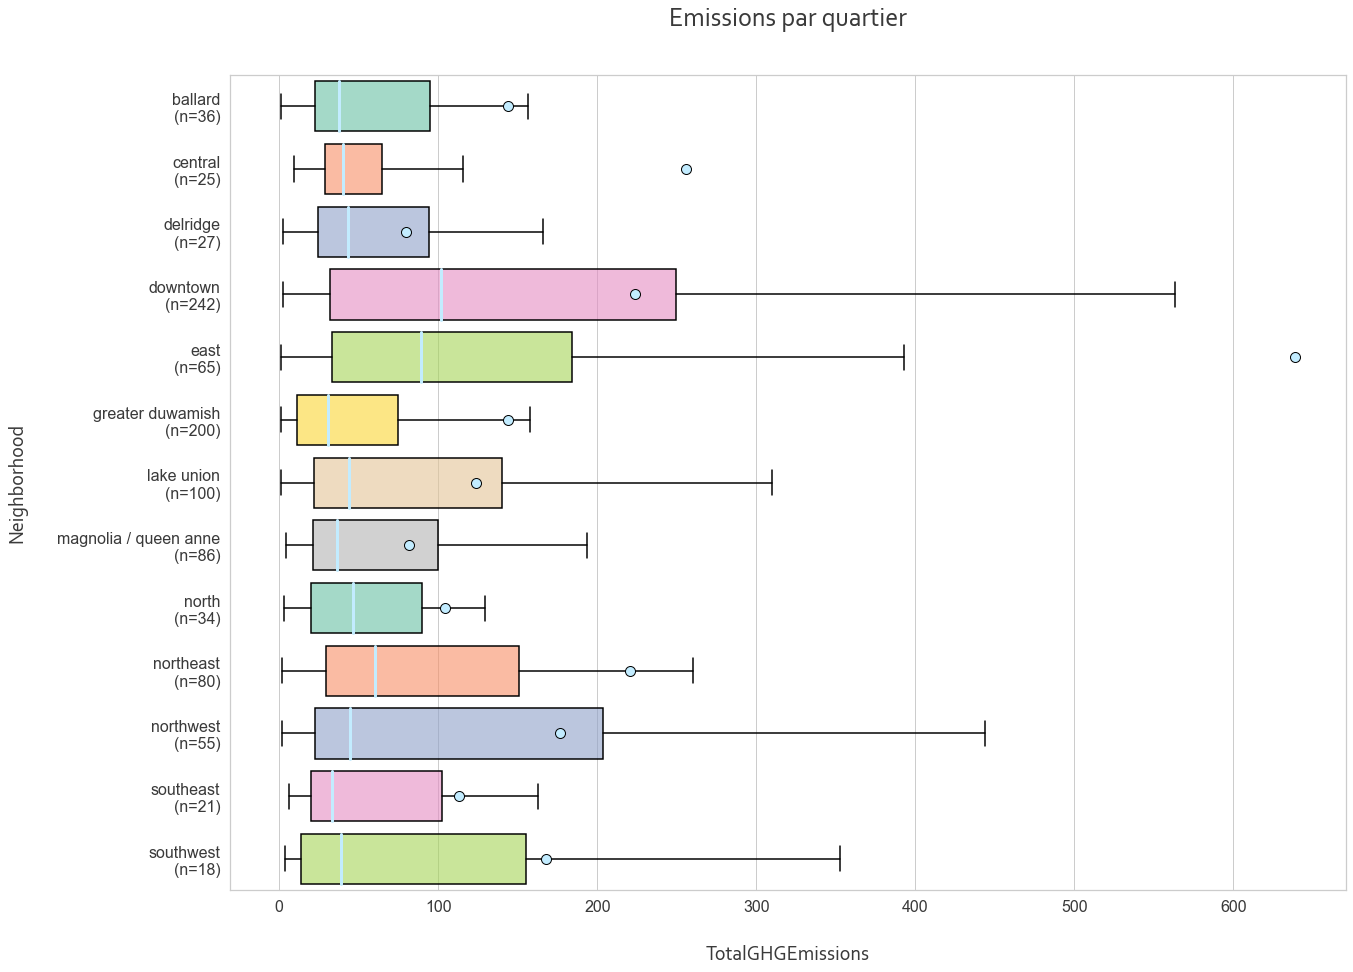

In [54]:
title_boxplot = 'Emissions par quartier\n'

toolbox.plot_boxplot(data_building.sort_values('Neighborhood'),
                     'TotalGHGEmissions',
                     title_boxplot,
                     (20, 15),
                     'Neighborhood')

<h5 style="font-family:Corbel Light; color:#737373">Sources d'énergie</h5>

Regardons si une des sources d'énergie est plus fortement corrélée à la cible émissions de CO2 que les autres.

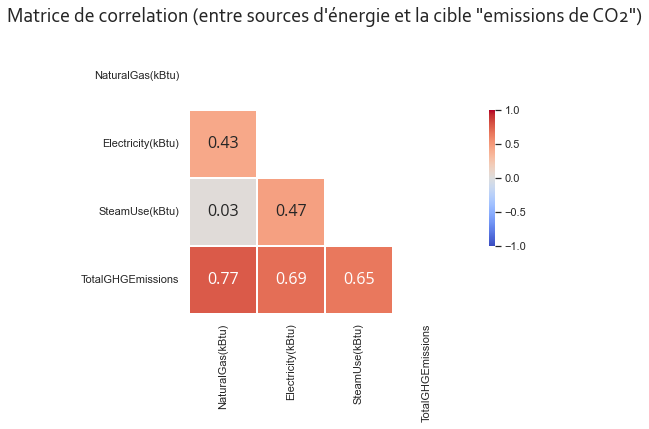

In [55]:
energy_source = ['NaturalGas(kBtu)', 'Electricity(kBtu)',
                 'SteamUse(kBtu)', 'TotalGHGEmissions']

matrix_title = 'Matrice de correlation (entre sources d\'énergie et la cible "emissions de CO2")'
correlation_matrix = data_building[energy_source].corr()

toolbox.plot_heatmap_correlation_matrix(correlation_matrix,
                                        matrix_title,
                                        (10, 5), 'coolwarm')

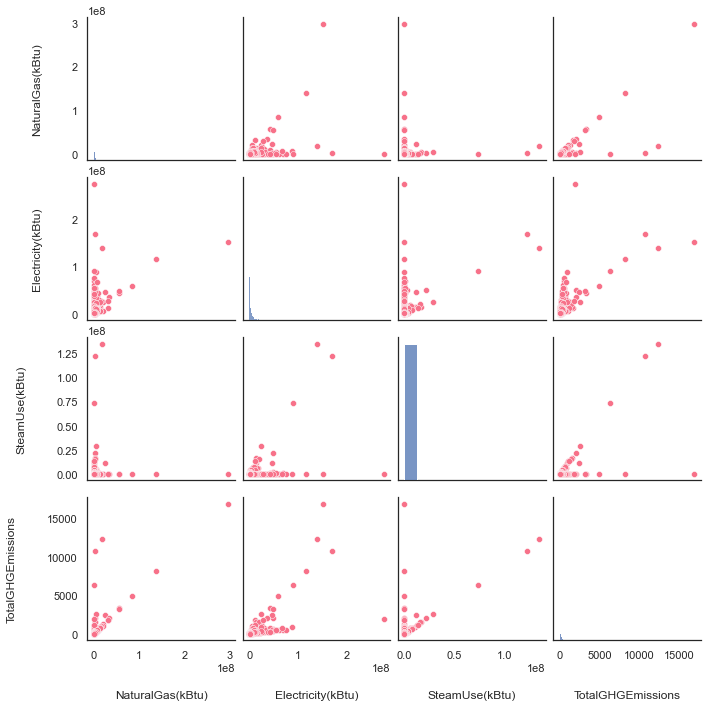

In [56]:
color = sns.color_palette("husl", 8)[0]
sns.pairplot(data_building, vars=energy_source,
             plot_kws=dict(color=color), dropna=True)
plt.show()

<h5 style="font-family:Corbel Light; color:#737373">Efficacité énergétique</h5>

On peut regarder si certains types de bâtiments émettent beaucoup plus ou beaucoup moins que les autres au regard de leur superficie

In [57]:
emission_byusetype = data_building.pivot_table(index='LargestPropertyUseType',
                                               values=['LargestPropertyUseTypeGFA', 'TotalGHGEmissions'],
                                               aggfunc='sum')

emission_byusetype = emission_byusetype.reset_index()
emission_byusetype.rename({'index': 'LargestPropertyUseType'}, inplace=True)
emission_byusetype.head()

,LargestPropertyUseType,LargestPropertyUseTypeGFA,TotalGHGEmissions
0,Bank Branch,84_847.00,38.45
1,Courthouse,537_150.00,1_265.29
2,Data Center,314_997.00,2_421.80
3,Distribution Center,2_496_908.00,2_249.58
4,Financial Office,173_224.00,225.75


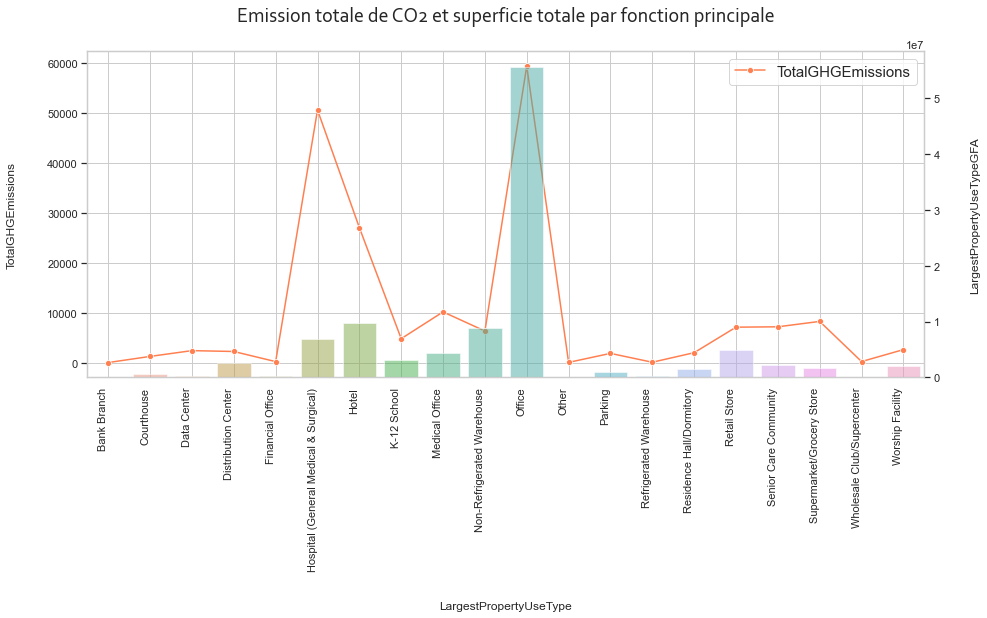

In [58]:
sns.set_theme(style='whitegrid')
fig, ax1 = plt.subplots(figsize=(15, 6))
sns.lineplot(data=emission_byusetype,
             x='LargestPropertyUseType',
             y='TotalGHGEmissions',
             marker='o',
             sort=False,
             ax=ax1,
             color='coral')

ax2 = ax1.twinx()

sns.barplot(data=emission_byusetype,
            x='LargestPropertyUseType',
            y='LargestPropertyUseTypeGFA',
            alpha=0.5,
            ax=ax2)

ax2.grid(False)

ax1.set_xticklabels(labels=ax2.axes.get_xticklabels(), rotation=90, ha='right')
ax1.legend(labels=['TotalGHGEmissions'], fontsize=15)

plt.title('Emission totale de CO2 et superficie totale par fonction principale',
          fontname='Corbel',
          fontsize=20,
          pad=30)

plt.show()

Les hopitaux et hotels semblent émettre beaucoup par rapport à leur superficie.

In [59]:
emission_intensity_byusetype = pd.DataFrame(data_building.groupby(
    'LargestPropertyUseType')['GHGEmissionsIntensity'].median()).reset_index()

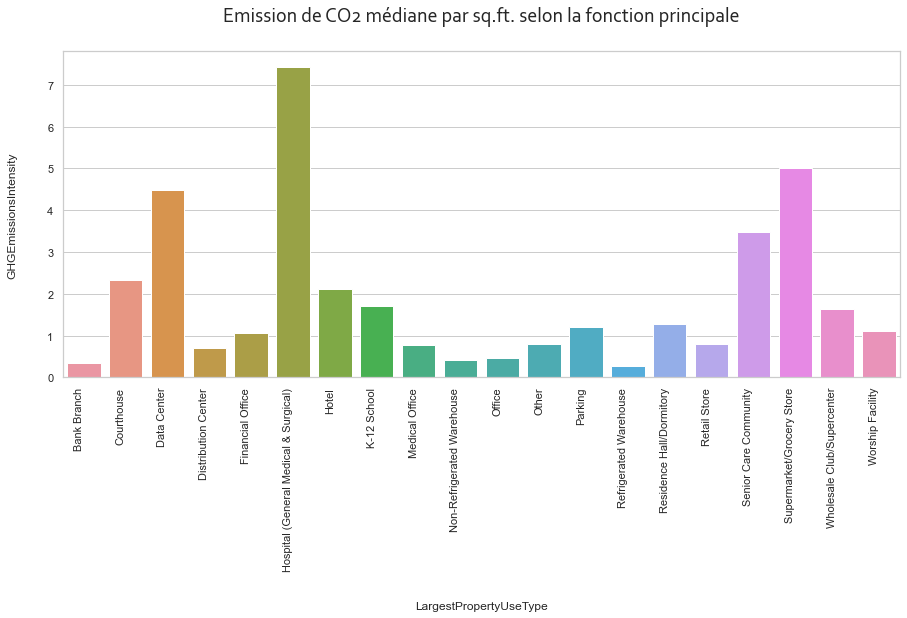

In [60]:
plt.figure(figsize=(15, 6))
sns.barplot(emission_intensity_byusetype,
            x='LargestPropertyUseType',
            y='GHGEmissionsIntensity')

plt.xticks(rotation=90, ha='right')
plt.title('Emission de CO2 médiane par sq.ft. selon la fonction principale',
          fontname='Corbel',
          fontsize=20,
          pad=30)

plt.show()

<h3 style="font-family:Corbel Light; color:#737373">Sauvegarde du jeu de données propre</h3>

In [61]:
data_building = data_building.reset_index()
data_building = data_building.drop(columns=['GHGEmissionsIntensity', 'SiteEUI(kBtu/sf)', 'index', 'ListOfAllPropertyUseTypes'])
data_building.shape

(989, 18)

In [62]:
data_building.to_pickle('2016_Building_Energy_Benchmarking_Cleaned.pkl')